# Working with `xarray.DataArray` data

## Step 1: Load libraries

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from matplotlib.patches import Patch

## Step 2: Load data

In [7]:
# Create a file path from the server that has our data
fp = os.path.join('/courses/EDS220/data/hwk4_landsat_data', 'landsat8-2018-01-26-sb-simplified.nc')

# Load in as a geospatial xarray 
landsat = rioxr.open_rasterio(fp)

In [8]:
# Load in our geospatial data frame that we exported in our last notebook
thomas_perimeter = gpd.read_file('data/thomas_perimeter/thomas_perimeter.shp')

## Step 3: Preliminary Exploration

In [9]:
# Preliminary exploration of data
# Xarray data doesn't have the same components as a geospatial data frame
# Can't use the same methods, view it and then unhide data
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

### Summary

The landsat data is not a dataframe, so we don't have to explore the data using the normal methods. This incudes `head()`, `info()`, `columns`, etc. When we call the data, it produces all that we need to. There are 4 coordinates consisting of a `band`, `x`, `y`, and `spatial_ref`. There are 5 data variables `red`, `green`, `blue`, `nir08`, and `swir22` that represent band types. There are 3 dimiensions `band`, `x`, and `y`. There is also an index consisting of `band`, `x`, and `y`.

## Step 4: Filtering

Notice that there is only a value of one in the band dimension. This means there is only one band, therefore we do not need to specify it as a dimension. We can filter this out using the following methods. 

In [10]:
# Drop the `band` coordinate of the data
landsat = landsat.drop_vars('band')

# Drop the `band` dimension of the data
# The code `squeeze` drops dimensions with values of 1 
landsat = landsat.squeeze()

# Check our array to confirm that `band` has been 
# removed from the dimensions and coordinates
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

## Step 5: Create a true and false color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


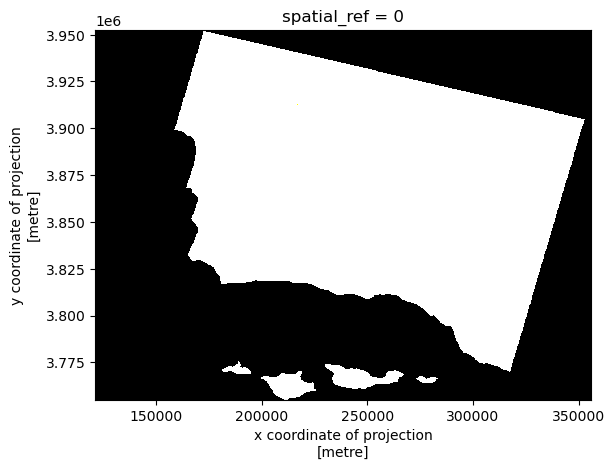

In [11]:
# Select red, green, and blue variables to be
# plotted as a true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

We selected the red, green, and blue bands, so why are we getting a black and white image? We need to slightly alter our code to get the output we want. The problem is the RGB values of the clouds. They are outliers and cause the other values to be squished when plotting. Use `robust = True` as an arugment in `.imshow` to use the 2nd and 98th percetiles of the data. This gets rid of the outliers. 

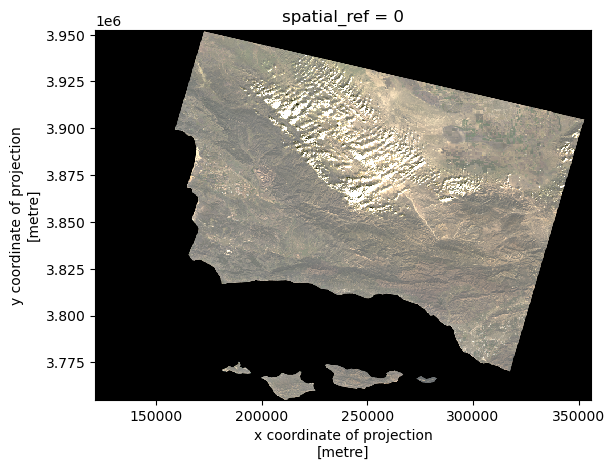

In [12]:
# Add the argument robust = True 
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

After changing the argument `robust = True` in `.imshow` we get a true color image. This is the output that we want to see. Using this code got rid of our cloud outliers data. 

### Let's create our false color image now

To do so we need to change the type of bands that we are plotting. Initially we selected the bands red, green, and blue to our red, green, and blue colors respectively. Now, we want to select the short-wave infrared (swir22), near-infrared (nir08), and red bands to the red, green, and blue colors respectively. 

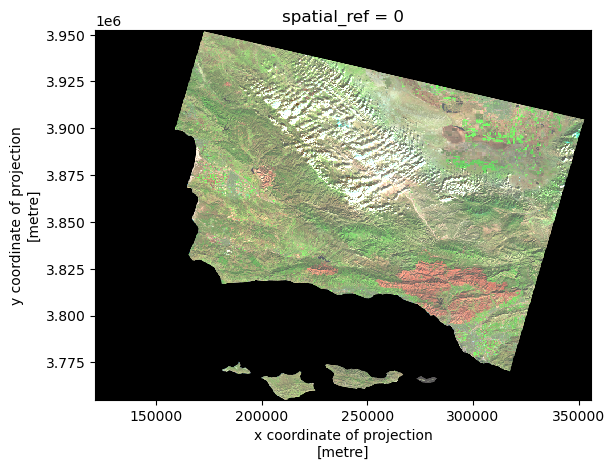

In [13]:
# Select swir22, nir08, and red as the variables to be plotted 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

## Step 6: Add the Thomas Fire perimeter to our false color image

Let's use the Thomas Fire perimeter that we created in the other notebook and add it to the false color image. This will give us an indication of where exactly to look when viewing the map. Remember, when working with spatial data, it is imperative to use the same CRS when comparing data. We know from before that our Thomas Fire data has a CRS of `EPSG:3857`, so let's use this as our base CRS. 

In [15]:
# Reproject our landsat data to EPSG:3857
landsat = landsat.rio.reproject("EPSG:3857")

# Check to see if the CRSs are the same
# By using assert we shouldn't see an output
assert landsat.rio.crs == thomas_perimeter.crs

In [ ]:
# Create a variable for the false color image map
false_color = landsat[['swir22', 'nir08', 'red']].to_array()

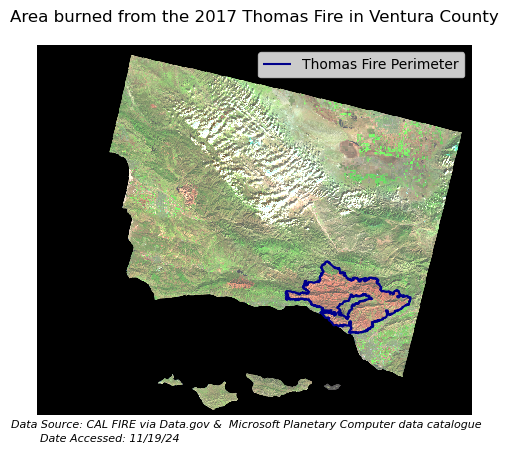

In [26]:
# Set up fig and ax
fig, ax = plt.subplots()

# False color image map
false_color.plot.imshow(robust = True, 
                        ax = ax,
                       alpha = 1)

# Fire perimeters
thomas_perimeter.boundary.plot(ax=ax,
                              color = 'darkblue')
                             
# Add a legend for the fire perimeter
ax.legend(labels = ['Thomas Fire Perimeter'])

# Add a title 
plt.title("Area burned from the 2017 Thomas Fire in Ventura County")
ax.axis('off')

# Add footnote citation at the bottom of the figure
fig.text(0.5, 0.09, 
         'Data Source: CAL FIRE via Data.gov &  Microsoft Planetary Computer data catalogue',
         ha='center', va='center', fontsize=8, color='black', fontstyle='italic')

fig.text(0.395, 0.06, 
         'Date Accessed: 11/19/24',
         ha='right', va='center', fontsize=8, color='black', fontstyle='italic')


plt.show()

Figure description: We have a false color image that contains the coast of Southern California along with the Thomas Fire perimeter. The red color in the map represents the short-wave infrared band which refers to burned area. The green color in the map represents near-infarared which is healthy vegetation. The blue color that isn't the fire perimeter represents the true color red. This map represents a clear indication of the area burned from the 2017 Thomas fire in Souther California. 